# Chapter 7: kMeans

### Exercise Overview: Applying k-Means to Real Data

In this exercise, we'll apply k-means clustering to three different real-world scenarios. This practical approach will help you understand:

1. **Data Preprocessing**
   - How to prepare different types of data for clustering
   - Handling missing values and scaling
   - Feature selection for clustering

2. **Implementation Challenges**
   - Choosing appropriate number of clusters
   - Dealing with different data shapes and sizes
   - Interpreting clustering results

3. **Result Interpretation**
   - Visualizing clusters in different ways
   - Understanding cluster characteristics
   - Validating clustering results

Each scenario presents unique challenges and learning opportunities. Remember: there's often no single "right" answer in clustering - the key is to make and justify reasonable choices based on your data and goals.

In [25]:
%matplotlib inline
low_memory=False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from scipy.stats import mode

## 7.1 Introduction & Motivation

In contrary to regression and classification, clustering is a bit more abstract. Instead of knowing what value we want to predict and what kind of values we can expect from it, we are now leaving all of that behind us and putting our trust in our created model. This time, we are passing our data and asking ourself the following question: within the given data, are there any **groups** or **clusters** of datapoints that belong together?

This kind of information might not seem as valueble as regression or classification at first glance, but is extremely useful in cases such as customer segmentation (so you know what your audience groups are and who to target), fraud detection (by identifying outliers who don't really fit in a cluster) or data organisations (such as grouping articles).

## 7.2 Problem Setting

In today's notebook we will be looking at two different datasets. First we will explore cluistering as segmentation mechanic using the mall customers dataset, after which we will try to mold it into a predictive model by revisiting the wine dataset.

The mall customers dataset contains data regarding, you guessed it, mall customers. Each customer has a certain gender, age, annual income (in k$) and a spending score between 0 and 100. We are trying to visulalize which groups of people have a similar spending power, so we can target our advertisements accordingly.

### Data Understanding: Key Points to Consider

When working with the Mall Customer Segmentation Data:

1. **Feature Understanding**
   - `CustomerID`: Unique identifier (not useful for clustering)
   - `Gender`: Categorical variable (needs encoding)
   - `Age`: Continuous variable (might need scaling)
   - `Annual Income (k$)`: Continuous variable (already in reasonable scale)
   - `Spending Score (1-100)`: Standardized score of spending behavior

2. **Business Context**
   - Retail analytics scenario
   - Goal: Group customers for targeted marketing
   - Common patterns might include:
     * High income, low spending (savers)
     * High income, high spending (prime customers)
     * Low income, high spending (potential credit risks)
     * Low income, low spending (budget conscious)

3. **Data Quality Considerations**
   - Check for missing values
   - Look for outliers
   - Consider feature relationships

This understanding will guide our preprocessing and modeling decisions.

## 7.3 Model

As always, let's have a look at the data first.

In [26]:
df = pd.read_csv('Mall_Customers.csv')
df.head(10)

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


##### Question 1: Try and plot a heatmap to further explore the data. If you run into any errors, fix it using a method we've seen before just like the previous exercise.

In [27]:
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df.head(10)

,CustomerID,Gender,Age,Annual Income,Spending Score
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40
5,6,1,22,17,76
6,7,1,35,18,6
7,8,1,23,18,94
8,9,0,64,19,3
9,10,1,30,19,72


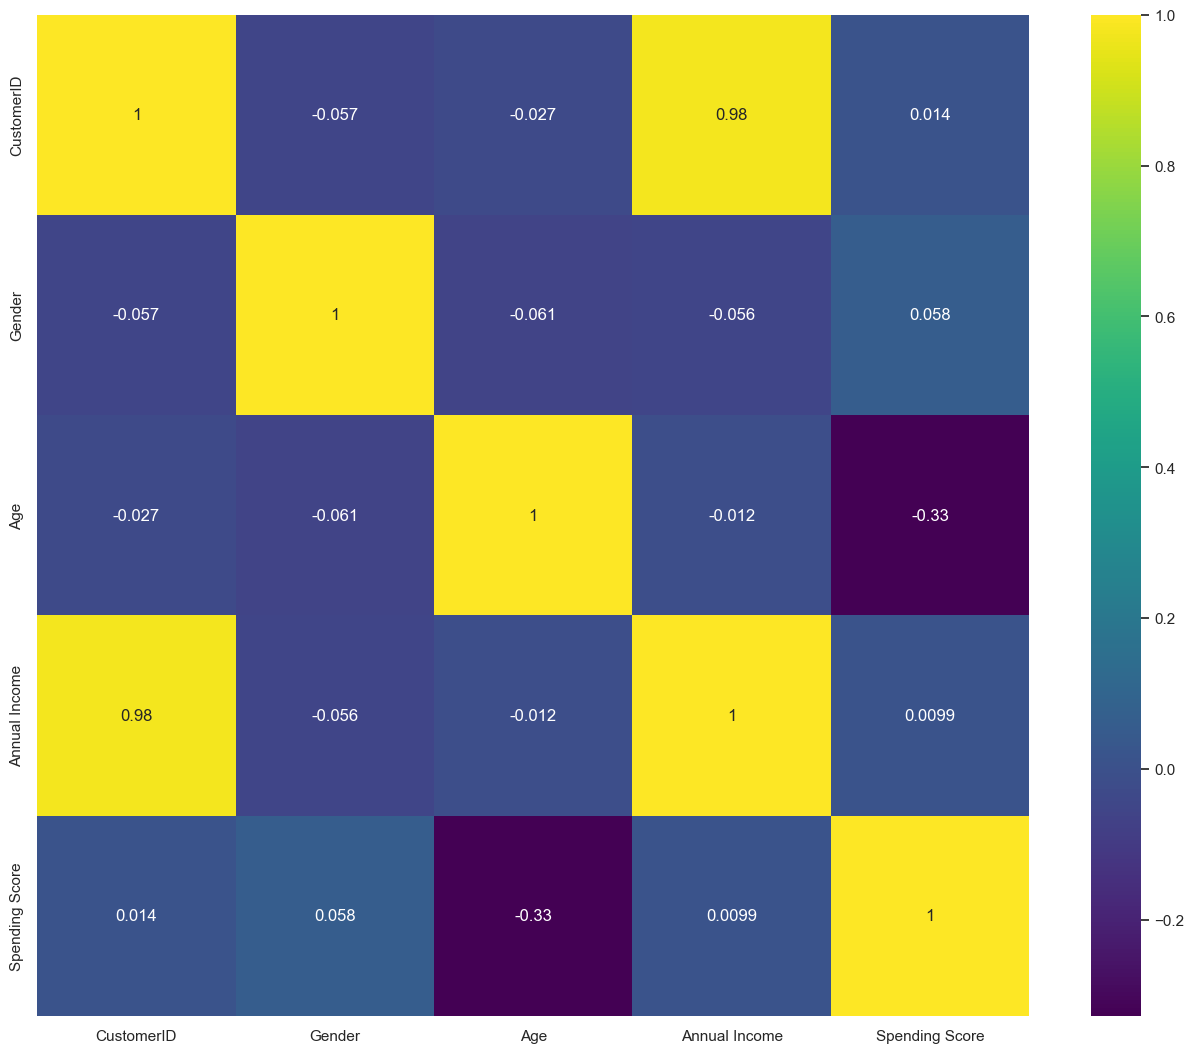

In [28]:
plt.figure(figsize=(16,13))
sns.heatmap(df.corr(),cmap='viridis', annot=True)
plt.show()

##### Question 2: Do you notice any strange or unexpected relation? Can you think of why this is? Is it pure chance or is there more going on?

We can see there is a relation between CustomerId and Annual income of near 1. This is quite unexpected and CustomerId is assigned randomly so this should not have a strong relation with any column. A small relation can be expected due to random noise, but a relation of nearly 1 is highly suspicious.

When looking at the data we can see that there is indeed a logical explanation for this correlation. We can see that the data is sorted based on Annual Income, meaning a lower Annual Income occurs ath the beginning of the dataset while a higher Annual Income occurs at the end of the dataset. Since customer id's are assigned sequentially, the same occurs in that column resulting in a high relation. Since CustomerID holds no real value we can discard this column, but it is an interesting phenomenon.

### Visualization Strategy: Making Data Talk

When visualizing clustering results, we want to tell a clear story. Here's our approach:

1. **Before Clustering**
   - Scatter plots to see natural groupings
   - Feature distributions to understand data spread
   - Correlation analysis to select features

2. **During Clustering**
   - Elbow plots to find optimal k
   - Silhouette analysis for cluster quality
   - Iteration tracking for convergence

3. **After Clustering**
   - Colored scatter plots to show assignments
   - Cluster centers to understand patterns
   - Profile plots for business interpretation

Remember: Good visualizations make complex patterns understandable to stakeholders!

## 7.4 Model Evaluation

##### Question 3: We will be trying to visualize our data. Since a simple to understand 2D plot can only support two variables (a dependant and an independant one) we are forced to limit our model to two variables. Our dependant variable will be Spending Score as that is what we are trying to visualize. Pick an independant variable and figure out the best value for k.

We are used to picking the column that has the highest or lowest relation to the column we desire, which in this case is Spending Score. Since Age has a low relation, we will pick this column to start.

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

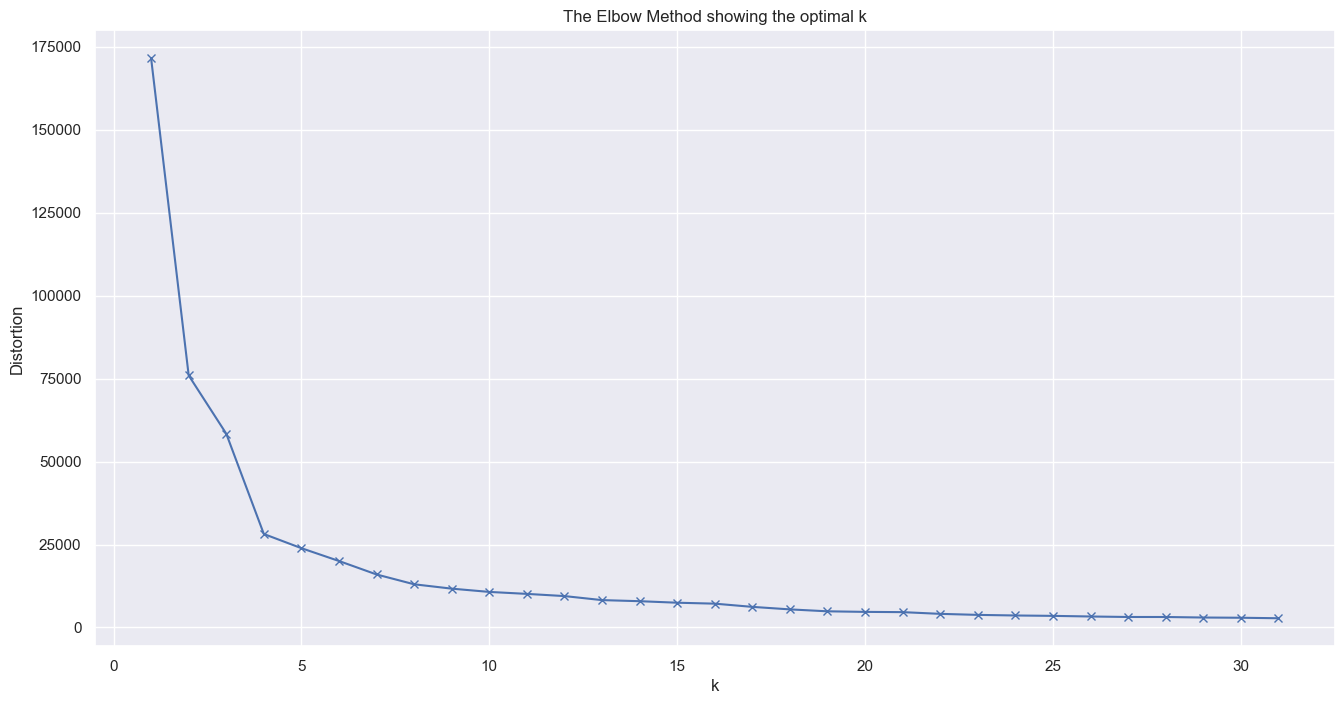

In [29]:
distortions = []
df_age = df[['Age', 'Spending Score']]
K = range(1,32)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=100)
    kmeanModel.fit(df_age)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The middle of our elbow lies at 4, so the best value for k is 4. When we plot our data, we will thus be expecting four groups or clusters.

##### Question 4: Plot a graph showing the Spending Score in function of the column you picked. Make sure you can visualize each individual cluster and its centroids.

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


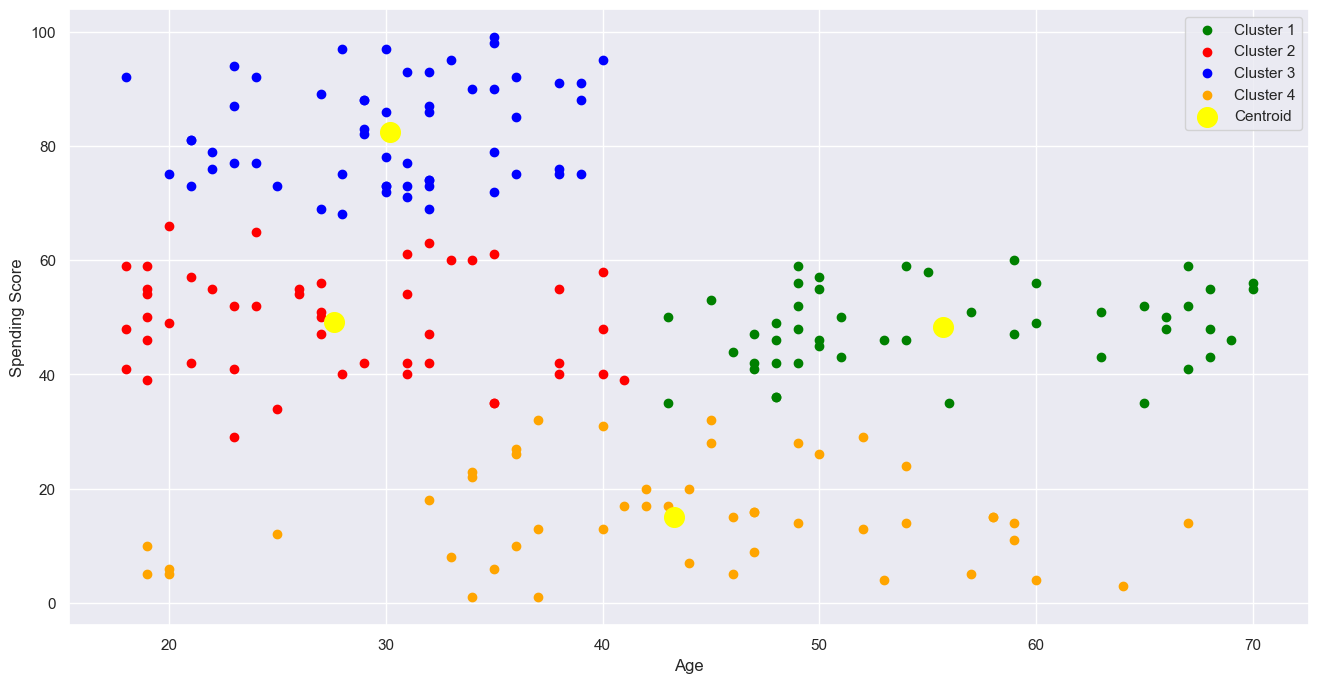

In [30]:
kmeanModel = KMeans(n_clusters=4, random_state=100)
clusters = kmeanModel.fit_predict(df_age)

#Plotting the clusters
fig,ax = plt.subplots(figsize=(16,8))
ax.scatter(df_age[clusters==0].iloc[:, 0], df_age[clusters==0].iloc[:, 1], c='green', label='Cluster 1')
ax.scatter(df_age[clusters==1].iloc[:, 0], df_age[clusters==1].iloc[:, 1], c='red', label='Cluster 2')
ax.scatter(df_age[clusters==2].iloc[:, 0], df_age[clusters==2].iloc[:, 1], c='blue', label='Cluster 3')
ax.scatter(df_age[clusters==3].iloc[:, 0], df_age[clusters==3].iloc[:, 1], c='orange', label='Cluster 4')

ax.scatter(kmeanModel.cluster_centers_[:,0],kmeanModel.cluster_centers_[:,1],s=200,c='yellow',label='Centroid')
plt.xlabel('Age')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

We can see four beautiful clusters get created! We see there are groups of customers, each of which we can target individually.

##### Question 5: You've explored the relation of one column with Spending Score, now explore all other columns. Are there any more insights to be revealed?

###### Clustering per Gender

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

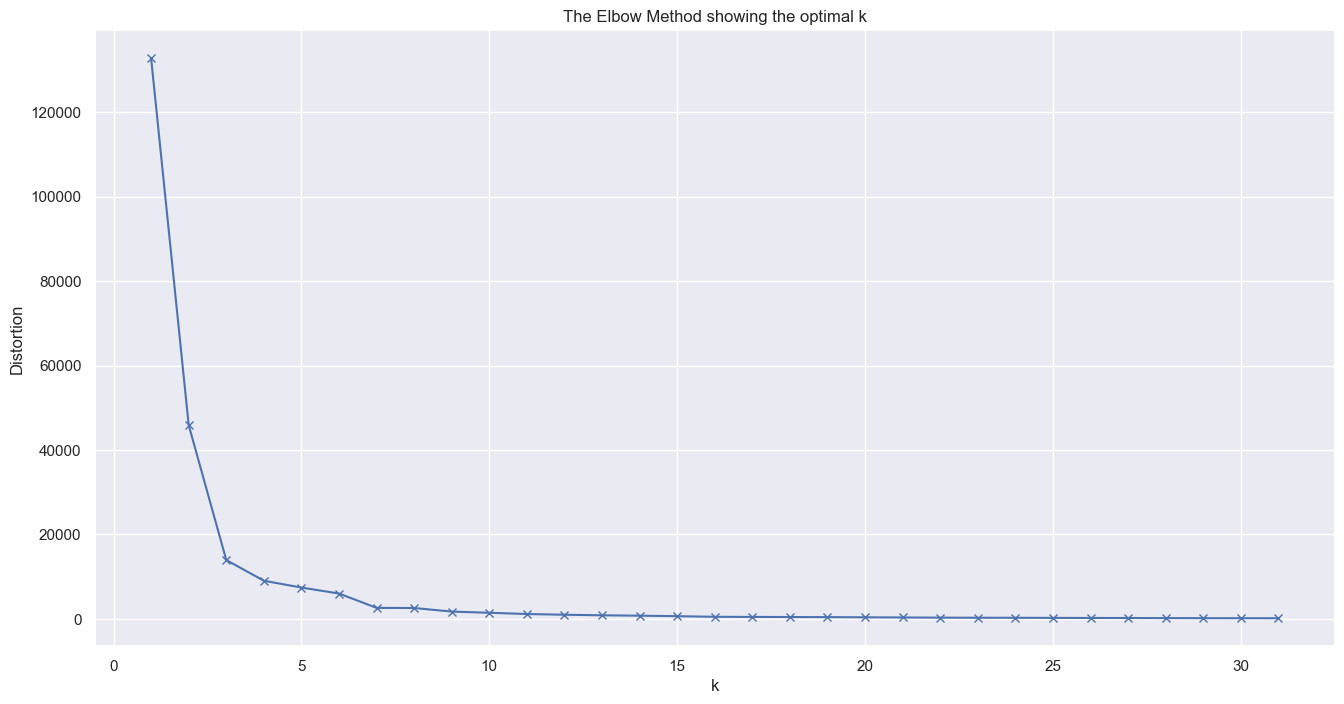

In [31]:
distortions = []
df_gender = df[['Gender', 'Spending Score']]
K = range(1,32)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=100)
    kmeanModel.fit(df_gender)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


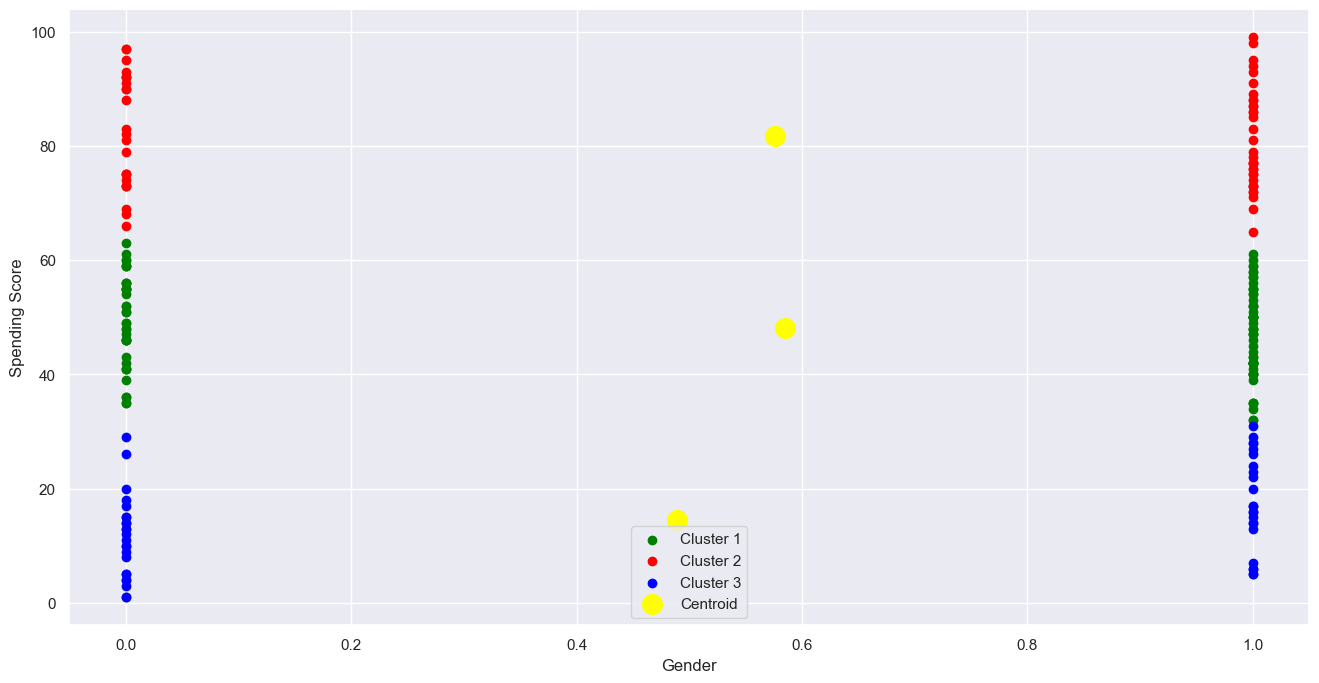

In [32]:
kmeanModel = KMeans(n_clusters=3, random_state=100)
clusters = kmeanModel.fit_predict(df_gender)

#Plotting the clusters
fig,ax = plt.subplots(figsize=(16,8))
ax.scatter(df_gender[clusters==0].iloc[:, 0], df_gender[clusters==0].iloc[:, 1], c='green', label='Cluster 1')
ax.scatter(df_gender[clusters==1].iloc[:, 0], df_gender[clusters==1].iloc[:, 1], c='red', label='Cluster 2')
ax.scatter(df_gender[clusters==2].iloc[:, 0], df_gender[clusters==2].iloc[:, 1], c='blue', label='Cluster 3')

ax.scatter(kmeanModel.cluster_centers_[:,0],kmeanModel.cluster_centers_[:,1],s=200,c='yellow',label='Centroid')
plt.xlabel('Gender')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

Clustering based on Gender does not tell us much about the data. Since gender is a binary column and all values are spread evenly, there isn't much of a cluster to speak of.

###### Clustering per Annual Income

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

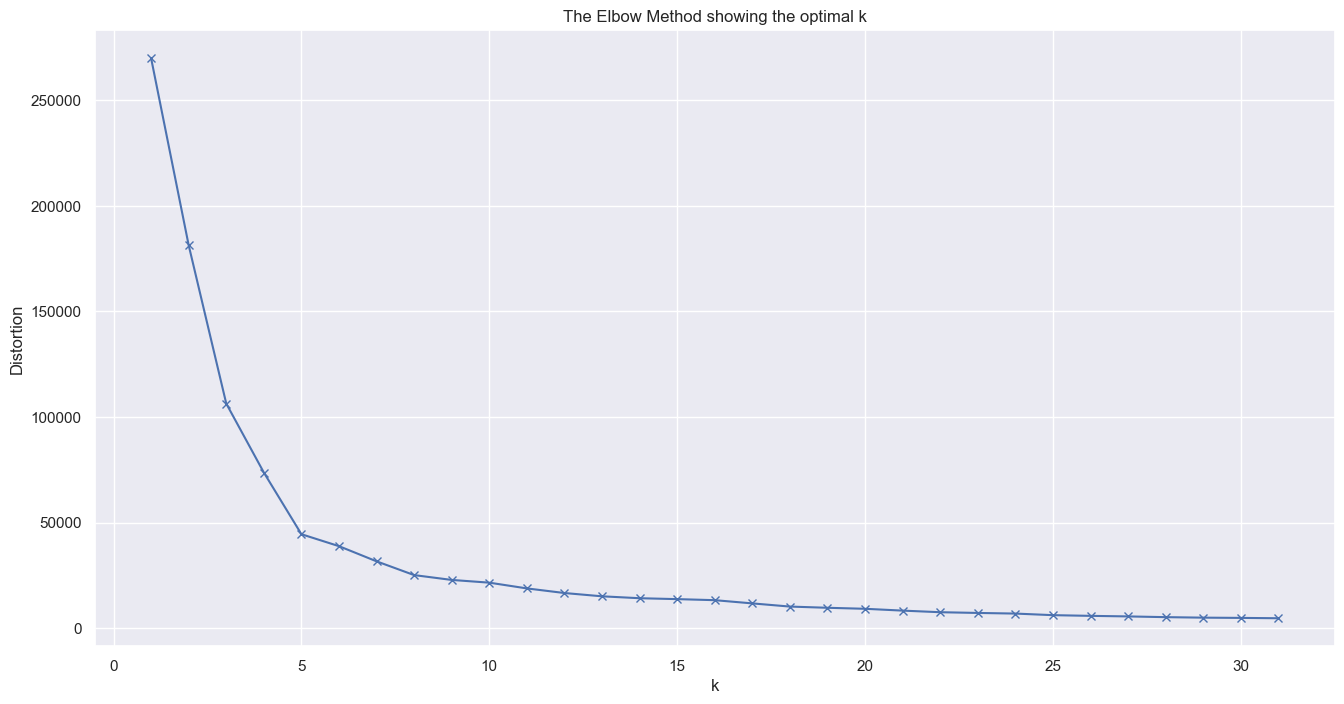

In [33]:
distortions = []
df_income = df[['Annual Income', 'Spending Score']]
K = range(1,32)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=100)
    kmeanModel.fit(df_income)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


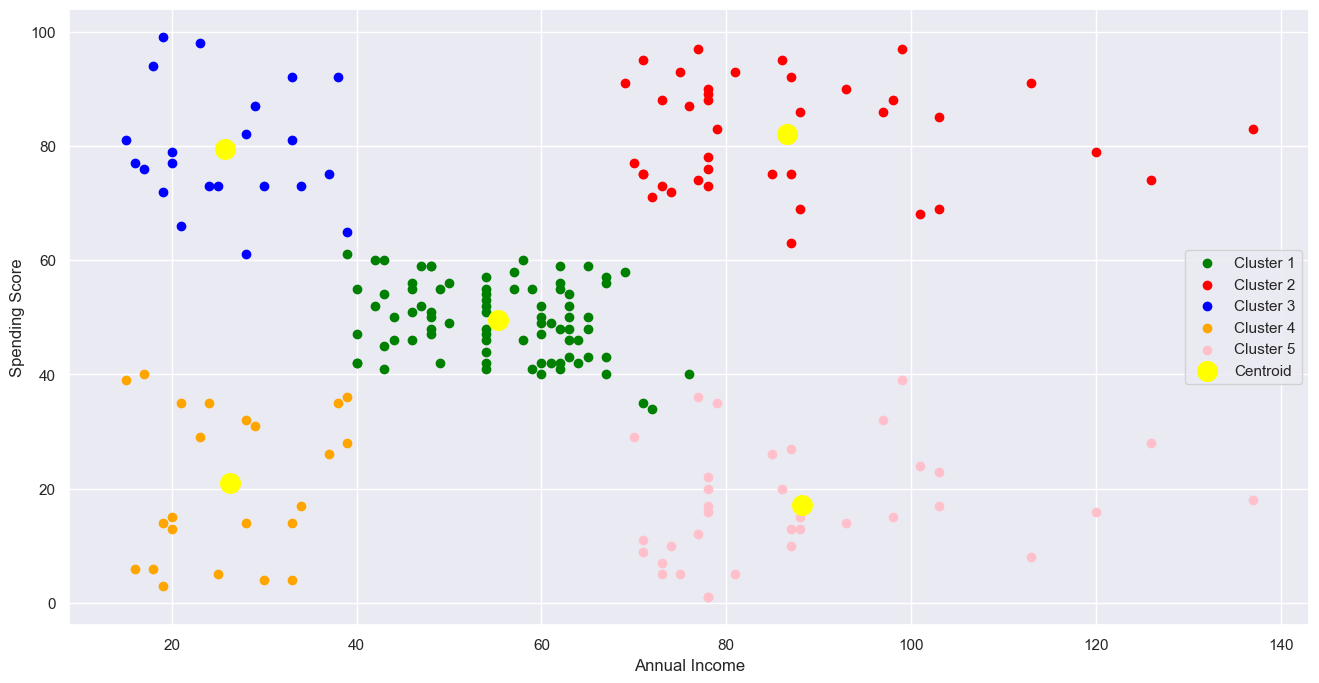

In [34]:
kmeanModel = KMeans(n_clusters=5, random_state=100)
clusters = kmeanModel.fit_predict(df_income)

#Plotting the clusters
fig,ax = plt.subplots(figsize=(16,8))
ax.scatter(df_income[clusters==0].iloc[:, 0], df_income[clusters==0].iloc[:, 1], c='green', label='Cluster 1')
ax.scatter(df_income[clusters==1].iloc[:, 0], df_income[clusters==1].iloc[:, 1], c='red', label='Cluster 2')
ax.scatter(df_income[clusters==2].iloc[:, 0], df_income[clusters==2].iloc[:, 1], c='blue', label='Cluster 3')
ax.scatter(df_income[clusters==3].iloc[:, 0], df_income[clusters==3].iloc[:, 1], c='orange', label='Cluster 4')
ax.scatter(df_income[clusters==4].iloc[:, 0], df_income[clusters==4].iloc[:, 1], c='pink', label='Cluster 5')

ax.scatter(kmeanModel.cluster_centers_[:,0],kmeanModel.cluster_centers_[:,1],s=200,c='yellow',label='Centroid')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.show()

Here we see something interesting going on. We can see that we clearly have some seperate clusters. We can see that Annual Income does not have a linear relation with spending score, but there is clearly some relation going on over here. This type of segmentation would not have been possible with regression and thus this information would have been unseen. Thanks to clustering we can now use this to create specific advertisement campaigns and create business value.

##### Question 6: Based on this, does our preferred value in the correlation matrix for picking columns still hold up? What would you change?

Normally, we are looking at high or low relations, as these indicate a strong linear relation. However, when using clustering we are not 
necessarily looking for a high relation. Instead, we are looking for groups or clusters of data. If anything, we might want to avoid high linear relations as this data tends to not contain any groups, as opposed to data with a low relation. We can visually see this by comparing a graph with a high linear relation (think back to linear regression for this) with our most recent graph of Annual Income, which has a really low relation.

Of course this is never for certain. We can have models with a low relation that contain no useable data (such as Gender) or columns with a high relation that do contain usable data (such as Age). The correlation matrix is a tool to help us pick our best columns, but it remains our responability to experiment with all columns and find the best data.

### Understanding Wine Quality Clustering

Now we'll apply clustering to the Wine dataset, which presents different challenges:

1. **Domain Context**
   - Wine quality assessment
   - Multiple chemical properties
   - Expert ratings available (but we'll ignore them for clustering)

2. **Technical Considerations**
   - Higher dimensionality (13 features)
   - Features on different scales
   - Complex feature interactions

3. **Analysis Goals**
   - Find natural groupings of wines
   - Identify key chemical properties that drive groupings
   - Compare clusters with expert ratings

This exercise shows how clustering can reveal natural patterns in complex, multi-dimensional data.

## 7.5 Questions

##### Question 1: See section 7.3
##### Question 2: See section 7.3
##### Question 3: See section 7.4
##### Question 4: See section 7.4
##### Question 5: See section 7.4
##### Question 6: See section 7.4
##### Question 7: Revisit the old wine dataset. Copy it to your current folder and import it. Drop the Id column just like we did in the notebook on decision trees.

In [35]:
df = pd.read_csv("Wine.csv")
df = df.drop(['Id'], axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##### Question 8: We want to explore the vizualization of quality as the dependant variable and all other variables. Calculate the best value of k for each graph (11 in total) and plot them. What can you learn from this?

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

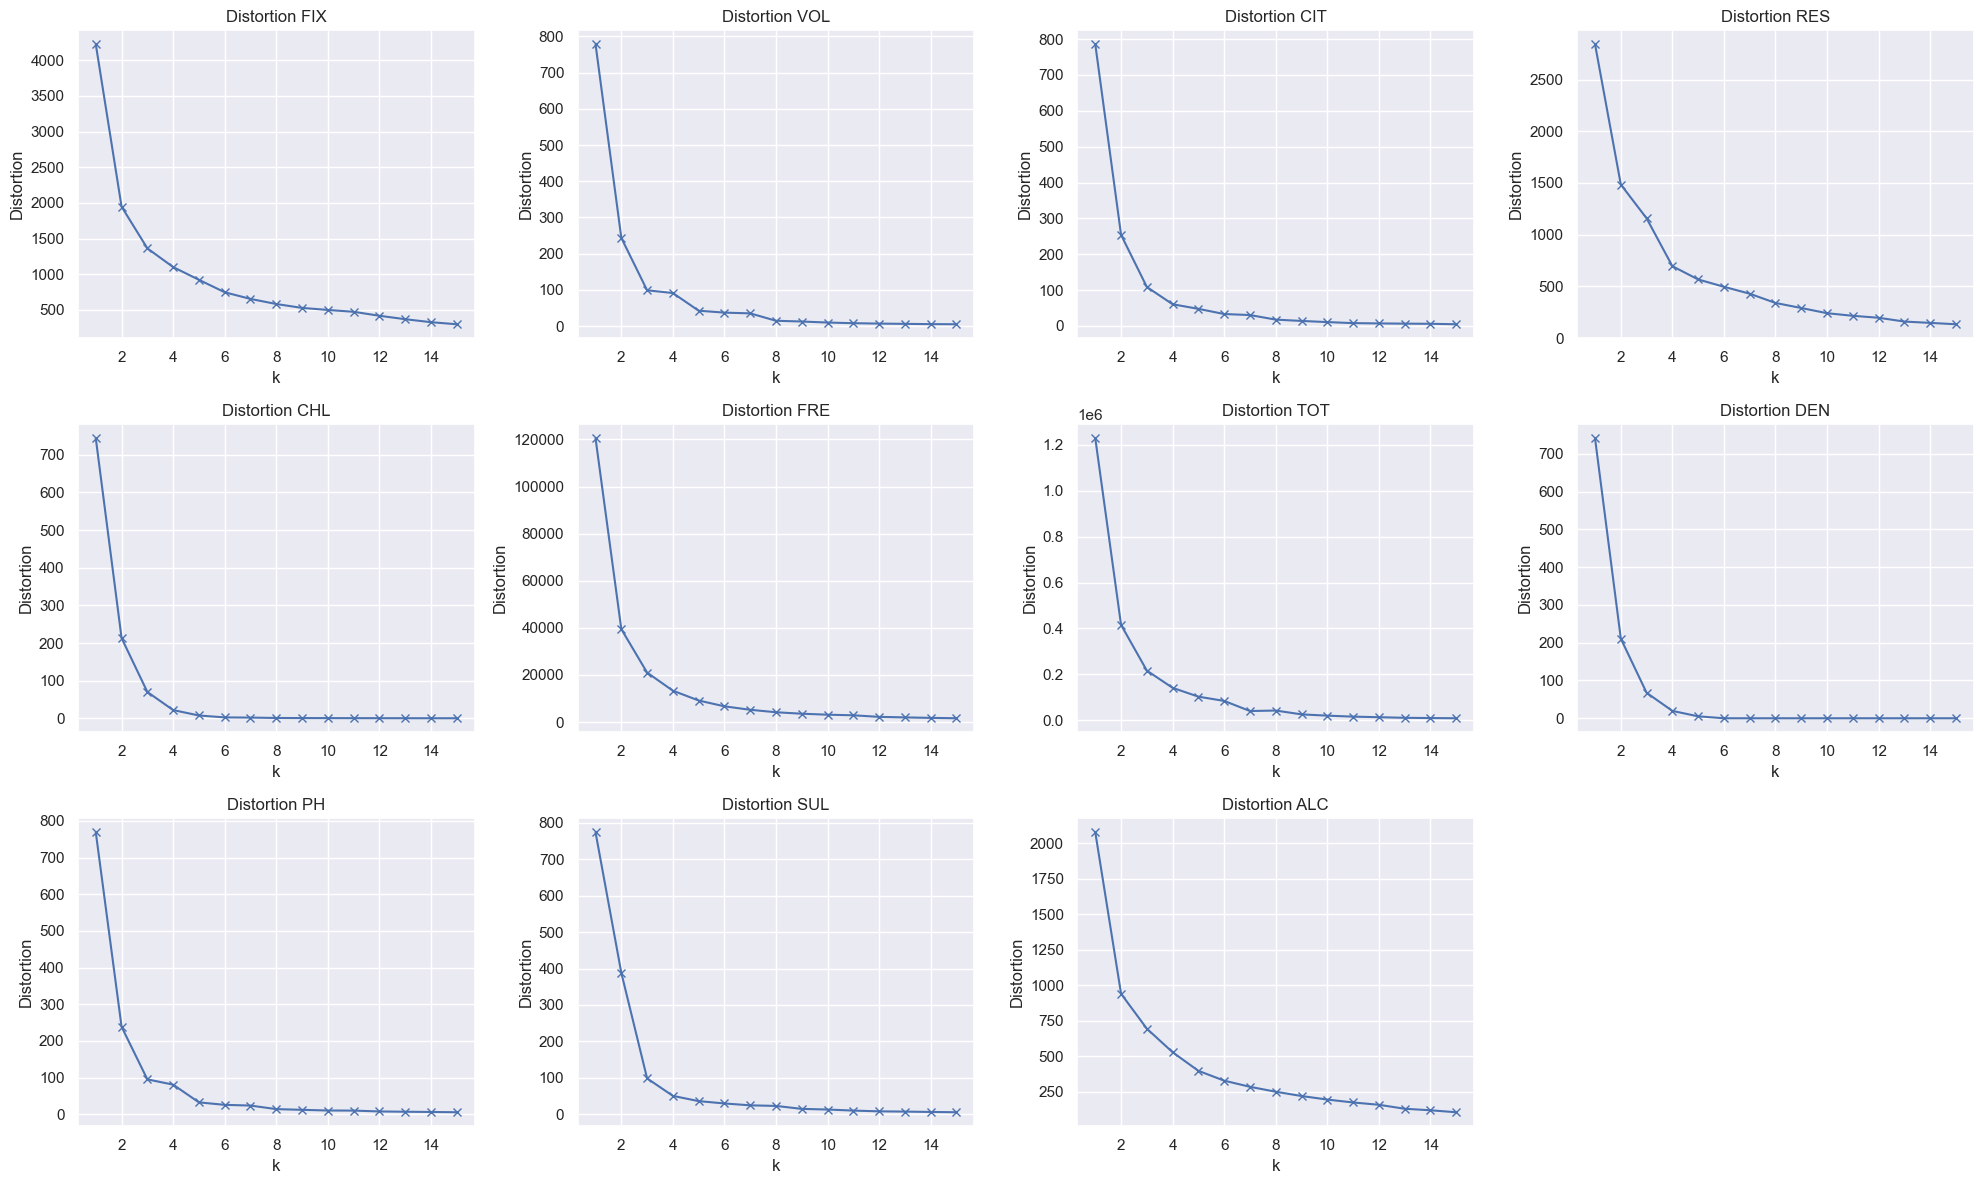

In [36]:
df_FIX = df[['fixed acidity', 'quality']]
df_VOL = df[['volatile acidity', 'quality']]
df_CIT = df[['citric acid', 'quality']]
df_RES = df[['residual sugar', 'quality']]
df_CHL = df[['chlorides', 'quality']]
df_FRE = df[['free sulfur dioxide', 'quality']]
df_TOT = df[['total sulfur dioxide', 'quality']]
df_DEN = df[['density', 'quality']]
df_PH = df[['pH', 'quality']]
df_SUL = df[['sulphates', 'quality']]
df_ALC = df[['alcohol', 'quality']]

distortions_FIX = []
distortions_VOL = []
distortions_CIT = []
distortions_RES = []
distortions_CHL = []
distortions_FRE = []
distortions_TOT = []
distortions_DEN = []
distortions_PH = []
distortions_SUL = []
distortions_ALC = []

K = range(1,16)

for k in K:
    kmeanModel_FIX = KMeans(n_clusters=k, random_state=100)
    kmeanModel_FIX.fit(df_FIX)
    distortions_FIX.append(kmeanModel_FIX.inertia_)
    kmeanModel_VOL = KMeans(n_clusters=k, random_state=100)
    kmeanModel_VOL.fit(df_VOL)
    distortions_VOL.append(kmeanModel_VOL.inertia_)
    kmeanModel_CIT = KMeans(n_clusters=k, random_state=100)
    kmeanModel_CIT.fit(df_CIT)
    distortions_CIT.append(kmeanModel_CIT.inertia_)
    kmeanModel_RES = KMeans(n_clusters=k, random_state=100)
    kmeanModel_RES.fit(df_RES)
    distortions_RES.append(kmeanModel_RES.inertia_)
    kmeanModel_CHL = KMeans(n_clusters=k, random_state=100)
    kmeanModel_CHL.fit(df_CHL)
    distortions_CHL.append(kmeanModel_CHL.inertia_)
    kmeanModel_FRE = KMeans(n_clusters=k, random_state=100)
    kmeanModel_FRE.fit(df_FRE)
    distortions_FRE.append(kmeanModel_FRE.inertia_)
    kmeanModel_TOT = KMeans(n_clusters=k, random_state=100)
    kmeanModel_TOT.fit(df_TOT)
    distortions_TOT.append(kmeanModel_TOT.inertia_)
    kmeanModel_DEN = KMeans(n_clusters=k, random_state=100)
    kmeanModel_DEN.fit(df_DEN)
    distortions_DEN.append(kmeanModel_DEN.inertia_)
    kmeanModel_PH = KMeans(n_clusters=k, random_state=100)
    kmeanModel_PH.fit(df_PH)
    distortions_PH.append(kmeanModel_PH.inertia_)
    kmeanModel_SUL = KMeans(n_clusters=k, random_state=100)
    kmeanModel_SUL.fit(df_SUL)
    distortions_SUL.append(kmeanModel_SUL.inertia_)
    kmeanModel_ALC = KMeans(n_clusters=k, random_state=100)
    kmeanModel_ALC.fit(df_ALC)
    distortions_ALC.append(kmeanModel_ALC.inertia_)

distortion_lists = [distortions_FIX, distortions_VOL, distortions_CIT, distortions_RES, distortions_CHL, distortions_FRE, distortions_TOT, distortions_DEN, distortions_PH, distortions_SUL, distortions_ALC]
titles = ['Distortion FIX', 'Distortion VOL', 'Distortion CIT', 'Distortion RES', 'Distortion CHL', 'Distortion FRE', 'Distortion TOT', 'Distortion DEN', 'Distortion PH', 'Distortion SUL', 'Distortion ALC']

fig, axes = plt.subplots(3, 4, figsize=(20, 12))  # 3 rows, 4 columns
axes = axes.flatten()

for i, (distortions, title) in enumerate(zip(distortion_lists, titles)):
    axes[i].plot(K, distortions, 'bx-')
    axes[i].set_xlabel('k')
    axes[i].set_ylabel('Distortion')
    axes[i].set_title(title)

# Hide the last subplot (empty subplot in 3x4 grid)
axes[-1].axis('off')

plt.tight_layout()
plt.show()

Most of the times the best value of k is 3. However, in some cases it is 2 (FRE), while in other cases it is 4 (RES) or 5 (ALC). We need to take this into account when plotting our final graphs.

c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

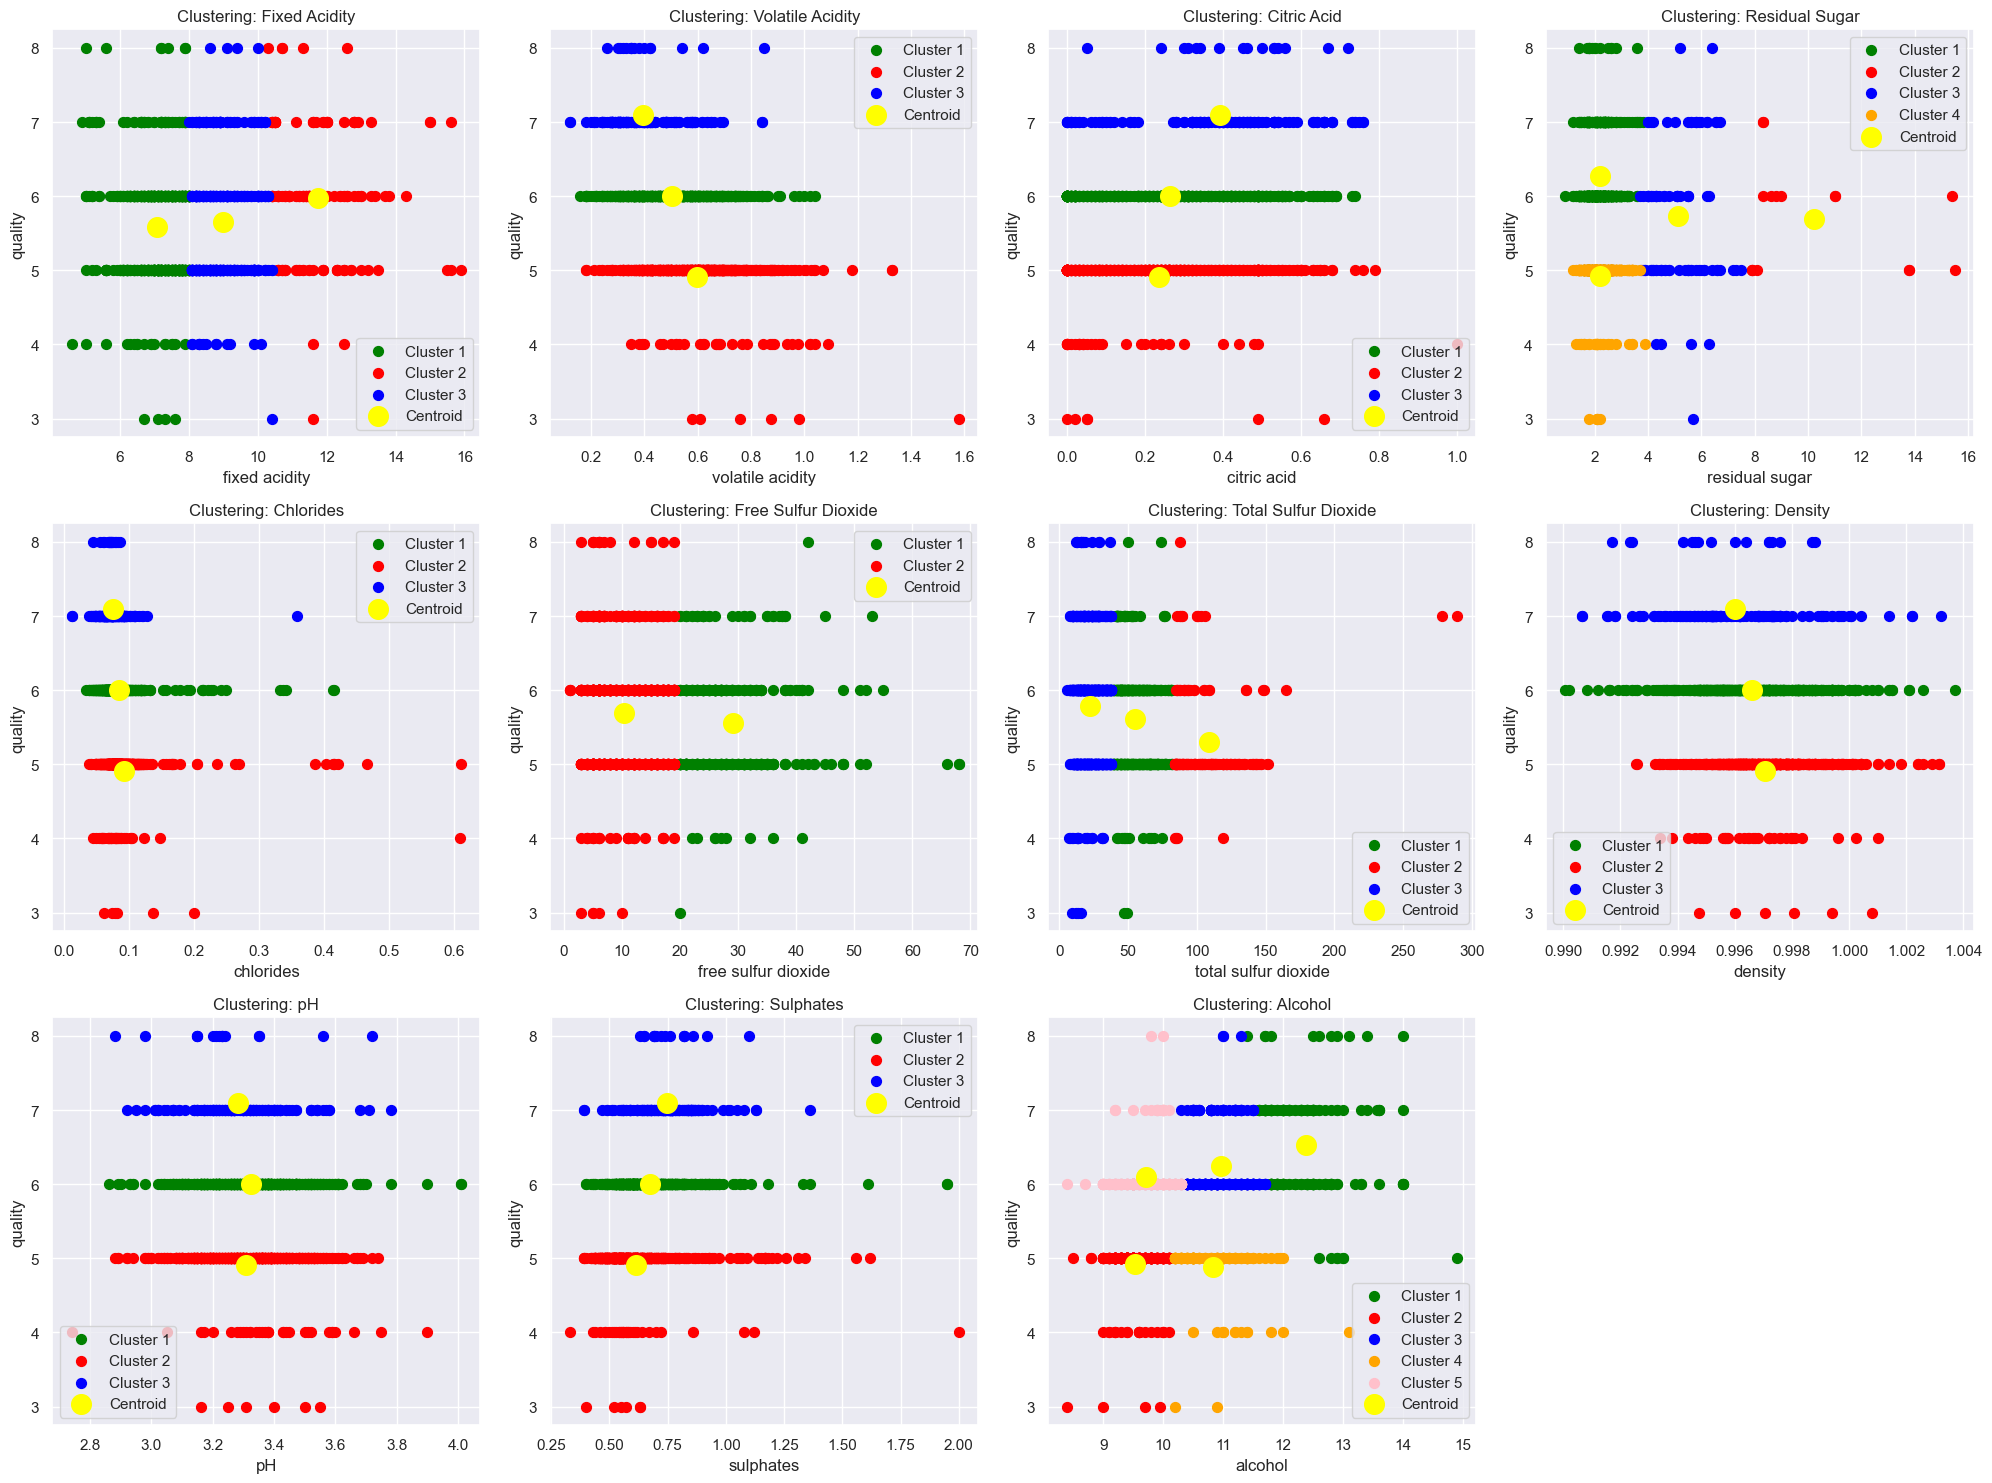

In [37]:
kmeanModel_FIX = KMeans(n_clusters=3, random_state=100)
kmeanModel_FIX.fit(df_FIX)
kmeanModel_VOL = KMeans(n_clusters=3, random_state=100)
kmeanModel_VOL.fit(df_VOL)
kmeanModel_CIT = KMeans(n_clusters=3, random_state=100)
kmeanModel_CIT.fit(df_CIT)
kmeanModel_RES = KMeans(n_clusters=4, random_state=100)
kmeanModel_RES.fit(df_RES)
kmeanModel_CHL = KMeans(n_clusters=3, random_state=100)
kmeanModel_CHL.fit(df_CHL)
kmeanModel_FRE = KMeans(n_clusters=2, random_state=100)
kmeanModel_FRE.fit(df_FRE)
kmeanModel_TOT = KMeans(n_clusters=3, random_state=100)
kmeanModel_TOT.fit(df_TOT)
kmeanModel_DEN = KMeans(n_clusters=3, random_state=100)
kmeanModel_DEN.fit(df_DEN)
kmeanModel_PH = KMeans(n_clusters=3, random_state=100)
kmeanModel_PH.fit(df_PH)
kmeanModel_SUL = KMeans(n_clusters=3, random_state=100)
kmeanModel_SUL.fit(df_SUL)
kmeanModel_ALC = KMeans(n_clusters=5, random_state=100)
kmeanModel_ALC.fit(df_ALC)

# List of dataframes and corresponding KMeans models
dataframes = [df_FIX, df_VOL, df_CIT, df_RES, df_CHL, df_FRE, df_TOT, df_DEN, df_PH, df_SUL, df_ALC]
models = [kmeanModel_FIX, kmeanModel_VOL, kmeanModel_CIT, kmeanModel_RES, kmeanModel_CHL, kmeanModel_FRE, kmeanModel_TOT, kmeanModel_DEN, kmeanModel_PH, kmeanModel_SUL, kmeanModel_ALC]
titles = ['Fixed Acidity', 'Volatile Acidity', 'Citric Acid', 'Residual Sugar', 'Chlorides', 'Free Sulfur Dioxide', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']

fig, axes = plt.subplots(3, 4, figsize=(20, 15))  # 3x4 grid
axes = axes.flatten()

for i, (df, model, title) in enumerate(zip(dataframes, models, titles)):
    clusters = model.predict(df)  # Predict the cluster for each point
    n_clusters = model.n_clusters  # Get the number of clusters for the current model
    
    colors = ['green', 'red', 'blue', 'orange', 'pink']  # Adjust if more colors are needed
    for j in range(n_clusters):
        axes[i].scatter(df[clusters == j].iloc[:, 0], df[clusters == j].iloc[:, 1], 
                        c=colors[j], label=f'Cluster {j+1}', s=50)
    axes[i].scatter(model.cluster_centers_[:,0],model.cluster_centers_[:,1],s=200,c='yellow',label='Centroid')
    axes[i].set_title(f'Clustering: {title}')
    axes[i].set_xlabel(df.columns[0])
    axes[i].set_ylabel(df.columns[1])
    axes[i].legend()

axes[-1].axis('off')
plt.tight_layout()
plt.show()

We can see we have created our graphs. Because Quality is a column with limited unique values, our data becomes slightly harder to interpret as with the mall customer data. However, we can still clearly see some groups. Perhaps the clearest example is with Residual Sugar, where we can see the red group exists of mostly outliers.

We could for example use this data when looking at the Alcohol graph to promote certain wines in the pink cluster which contain a low amount of alcohol but have a high quality. There are plenty more examples of what we can do with this data, as each group represents their own type of wine.

### Key Insights from Our Analysis

Let's summarize what we've learned from both datasets:

1. **Mall Customer Segmentation**
   - Found natural customer segments based on spending and income
   - Identified potential target groups for marketing
   - Demonstrated importance of feature selection
   - Showed how to validate cluster numbers

2. **Wine Classification**
   - Revealed natural groupings in chemical properties
   - Demonstrated clustering with high-dimensional data
   - Showed relationship between clusters and quality
   - Illustrated importance of feature scaling

3. **General Lessons**
   - Importance of data preprocessing
   - Value of visualization in understanding clusters
   - Need for business context in interpretation
   - Balance between mathematical and practical considerations

These insights can be applied to many real-world clustering problems!

##### Question 9: Try and use clustering as a way to predict your quality. Feel free to use all columns for this model. Think of how many clusters you would expect in this case!

In [38]:
from collections import Counter

In [39]:
df_X = df.drop(['quality'], axis=1)
df_y = df['quality'].to_numpy()

kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(df_X)
kmeans.cluster_centers_.shape
picked_values = []

labels = np.zeros_like(clusters)
for i in range(6):
    mask = (clusters == i)
    
    values = df_y[mask]
    value_counts = Counter(values).most_common()

    for val in (value_counts):
        if val[0] not in picked_values:
            picked_values.append(val[0])
            labels[mask] = val[0]
            print(f'Initial value would be {mode(df_y[mask])[0]} but picked value is {val[0]}')
            break

Initial value would be 6 but picked value is 6
Initial value would be 5 but picked value is 5
Initial value would be 6 but picked value is 7
Initial value would be 6 but picked value is 4
Initial value would be 6 but picked value is 8
Initial value would be 5 but picked value is 3


c:\Users\billo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


In [40]:
import sys
np.set_printoptions(threshold=sys.maxsize)

print(labels)

[3 5 5 5 3 3 3 5 5 3 5 3 4 3 5 5 3 5 3 5 3 5 4 5 3 5 4 5 4 3 4 4 8 3 3 3 3
 3 4 5 5 3 3 3 5 6 6 4 4 5 3 4 4 4 3 3 3 4 4 5 5 5 3 5 5 5 4 4 5 3 4 3 3 3
 3 3 3 5 5 5 5 4 5 3 6 3 5 6 6 4 3 8 5 5 3 5 8 3 8 3 5 4 4 3 4 4 4 4 4 3 3
 5 3 5 3 3 5 4 3 4 3 3 6 5 5 4 5 5 5 3 3 3 3 5 3 5 3 5 5 5 4 4 6 4 3 4 4 3
 7 5 4 5 4 6 3 5 3 3 5 5 4 5 7 5 5 3 3 3 6 5 3 3 5 5 5 5 5 4 5 3 3 3 3 4 3
 3 5 3 6 5 7 3 4 4 4 3 4 7 4 3 5 4 5 5 4 4 4 3 4 4 4 5 5 5 5 5 4 4 5 3 3 5
 5 3 5 3 6 6 4 5 3 3 6 6 5 6 6 7 7 4 5 5 5 4 7 5 3 3 8 7 7 6 6 4 5 3 5 5 4
 5 5 3 7 3 4 6 7 8 3 3 3 7 5 5 8 5 6 3 5 4 4 3 4 4 5 5 3 6 5 3 6 4 4 5 7 6
 6 7 6 4 3 4 6 3 5 5 5 4 6 3 5 6 7 4 6 4 4 4 5 6 6 8 4 5 3 6 3 3 6 8 3 5 4
 6 4 4 5 6 4 3 6 3 5 5 4 8 8 6 7 6 3 6 6 6 3 7 7 4 7 4 5 6 4 5 6 6 3 7 3 5
 3 5 6 3 4 4 4 7 5 4 3 4 7 6 5 6 5 6 3 3 5 4 4 5 5 5 6 6 6 6 7 6 3 4 7 6 3
 4 6 6 4 5 5 5 5 5 5 5 3 8 5 6 5 3 3 3 5 3 3 4 4 7 3 3 5 5 5 3 3 3 5 4 3 3
 3 3 3 5 4 6 5 5 3 3 4 3 3 3 6 6 6 5 8 7 5 3 5 4 5 5 3 5 5 5 3 3 5 5 3 5 5
 5 4 5 6 3 6 3 3 5 3 3 3 

##### Question 10: Evaluate the model. Is it any good for this kind of prediction? Why is this? Are there any noteable differences when seen against predicting the digits dataset? What makes a dataset 'good' to use with clustering for predicting a value? Elaborate based on your findings from question 8 and 9.

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

score = accuracy_score(df_y, labels)
mat = confusion_matrix(df_y, labels)
qualities = [3, 4, 5, 6 ,7 , 8]

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=qualities, yticklabels=qualities, cmap="Blues")
plt.title(score)
plt.xlabel('true label')
plt.ylabel('predicted label');

Our accuracy score is only 0.32, meaning we only have an accuracy of 32%. This is extremely low. We can see this visually in the confusion matrix, where we do have quite a lot of high values on the diagonal, but also a lot more wrong predictions.

We can thus conclude that using clustering as a way to predict labels does not work on every dataset. But where do we draw the line? When does a dataset work with clustering? In reality, the answer is 'not often'. Clustering works by looking at similar datapoints and grouping them together. We have seen in question 8 that there are quite a lot of 'groups' of wine with varying quality. One group does not necessarily indicate a similar quality.

This is in contrast to our digits dataset, where each group we have will represent the same digit. Because of this, the digits dataset could work with clustering, while the wine dataset does not. At least not when it comes to predicting a dependant variable. There is still insight to be gained from using clustering on this dataset as we saw in question 8.

### Further Exploration Ideas

To deepen your understanding of clustering, consider these additional exercises:

1. **Feature Engineering**
   - Try creating new features from existing ones
   - Experiment with different scaling methods
   - Use dimensionality reduction (PCA) before clustering

2. **Alternative Approaches**
   - Compare with hierarchical clustering
   - Try DBSCAN for density-based clustering
   - Experiment with different distance metrics

3. **Validation Techniques**
   - Implement cross-validation for clustering
   - Use different cluster quality metrics
   - Compare results with domain expert knowledge

4. **Business Applications**
   - Create customer personas from clusters
   - Design targeted marketing strategies
   - Develop product recommendations

Remember: The best way to learn is through experimentation and real-world application!